<a href="https://colab.research.google.com/github/Rchatru/ML4DS/blob/master/assignment_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import os

In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

1. Add the following files to your drive:
https://drive.google.com/file/d/1gKJmVCODGcpCfgVtOgUzlxH1Q1Vf0KaR/view?usp=sharing
https://drive.google.com/file/d/1nydN6iEc-WEn1ZcOw3K1vjEonAuqWWOh/view?usp=sharing
2. In the drive interface, create a shortcut for both files
3. Mount your drive using the code below

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

Test

In [9]:
#df = pd.read_csv('/content/drive/MyDrive/train.csv')
filename = 'train.csv'
df = pd.read_csv(os.path.join(os.getcwd(),filename))

print(df.head())
print(df['Consumer_type'].value_counts())

   Year  Month Consumer_type  Consumption     Consumer_number  \
0  2013      1      domestic            0  MOGV36480546611521   
1  2013      1    industrial            5  BECS02817768252637   
2  2013      1      domestic            6  VRFW65577141436242   
3  2013      1      domestic            1  QLLI18662653137621   
4  2013      1      domestic           13  HYUO61823402850645   

     Installation_zone  
0  Installation_zone 1  
1  Installation_zone 2  
2  Installation_zone 2  
3  Installation_zone 2  
4  Installation_zone 2  
Consumer_type
domestic               236167
rural domestic          63086
industrial              21057
rural commercial         5541
construction             2235
low income families       999
rural expansion           890
Name: count, dtype: int64


## Preprocess


preprocess data

In [10]:
print(df.head())

   Year  Month Consumer_type  Consumption     Consumer_number  \
0  2013      1      domestic            0  MOGV36480546611521   
1  2013      1    industrial            5  BECS02817768252637   
2  2013      1      domestic            6  VRFW65577141436242   
3  2013      1      domestic            1  QLLI18662653137621   
4  2013      1      domestic           13  HYUO61823402850645   

     Installation_zone  
0  Installation_zone 1  
1  Installation_zone 2  
2  Installation_zone 2  
3  Installation_zone 2  
4  Installation_zone 2  


In [16]:
df.groupby('Installation_zone')['Consumer_type'].value_counts()

Installation_zone     Consumer_type      
Installation_zone 1   domestic               73358
                      industrial              3511
                      low income families      322
                      construction             230
                      rural commercial          51
Installation_zone 10  rural domestic          4157
                      rural expansion           59
                      construction              19
                      low income families        2
Installation_zone 11  rural domestic           990
                      rural expansion           13
                      construction              13
Installation_zone 12  rural domestic          1326
                      rural expansion           13
                      construction              11
                      industrial                10
Installation_zone 13  rural domestic          1688
                      construction               9
Installation_zone 14  rural domestic    

In [17]:
df.Consumer_number.nunique()

27632

## Analysis

dataset analysis

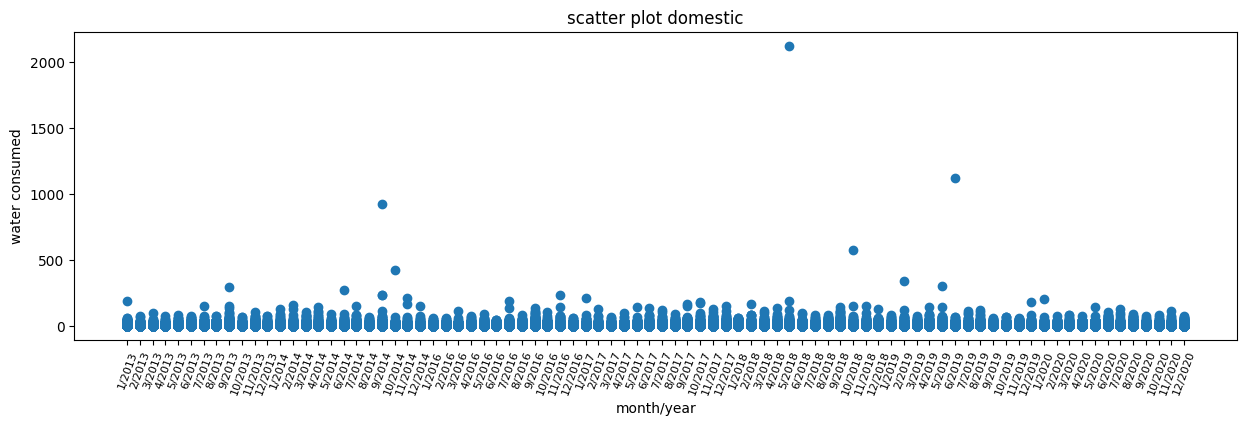

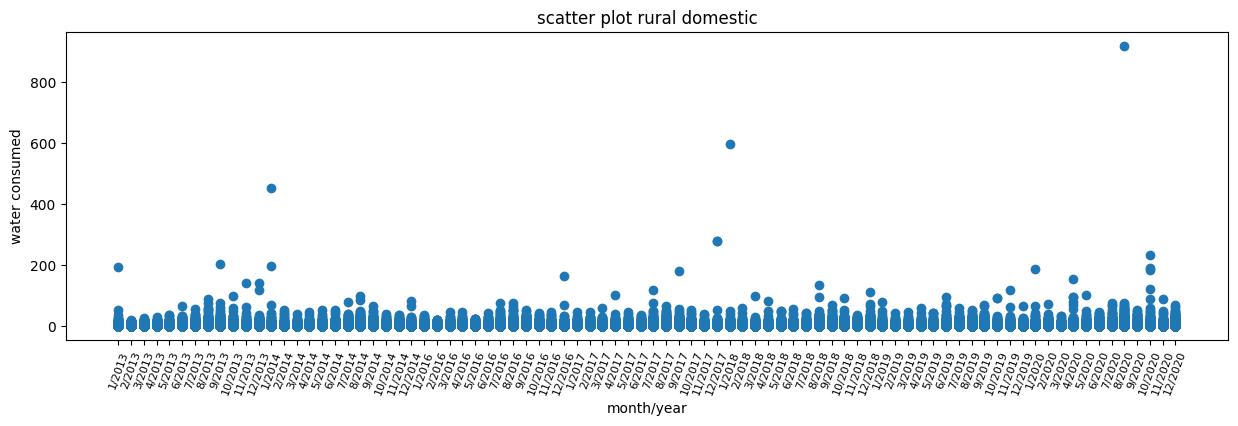

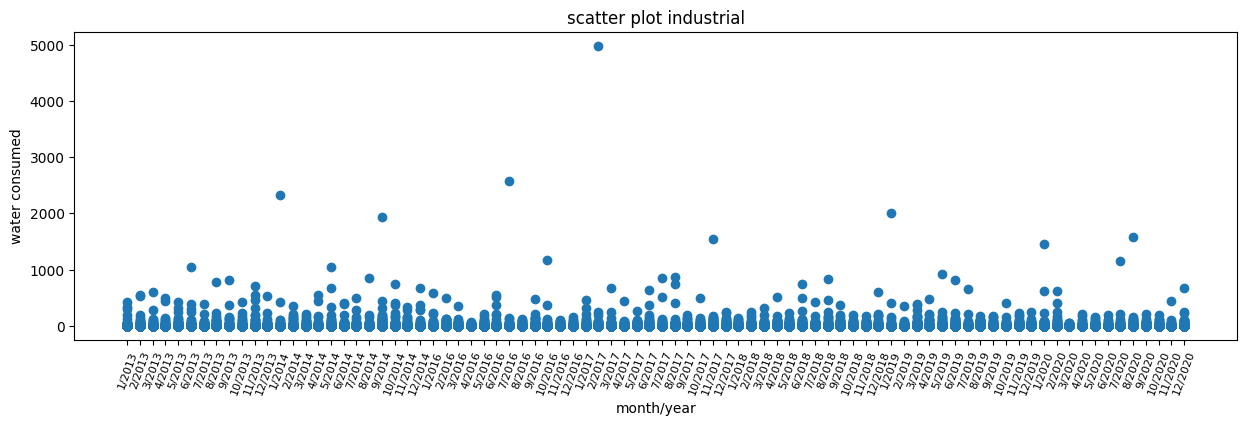

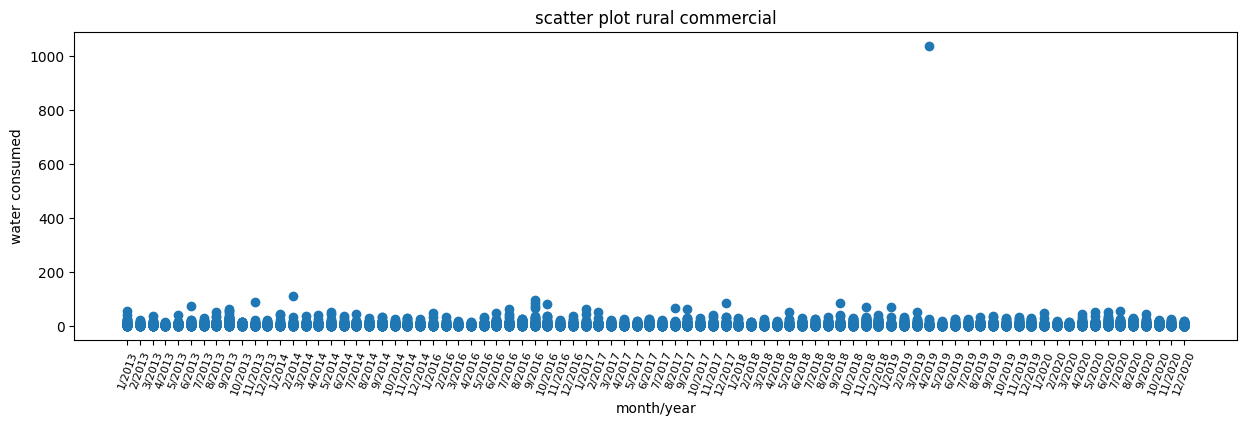

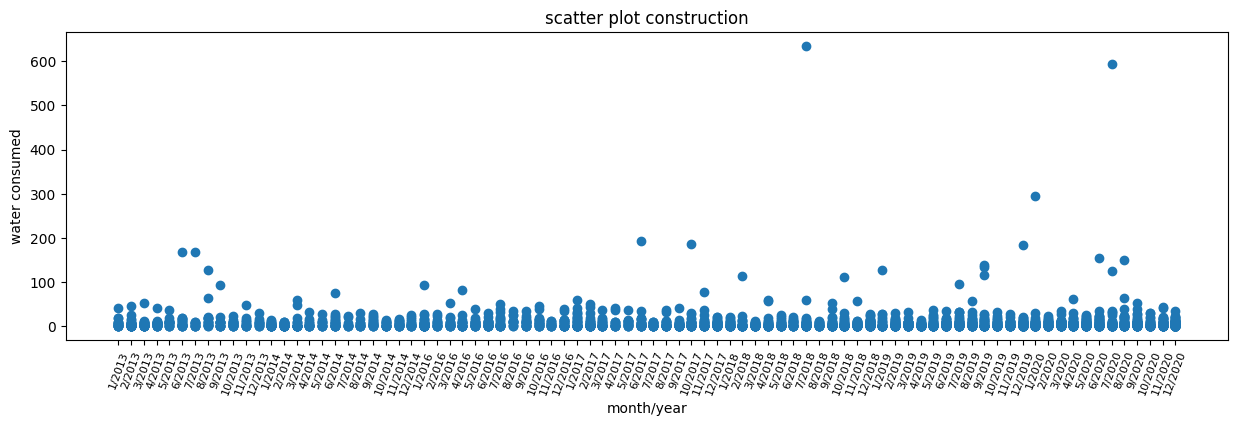

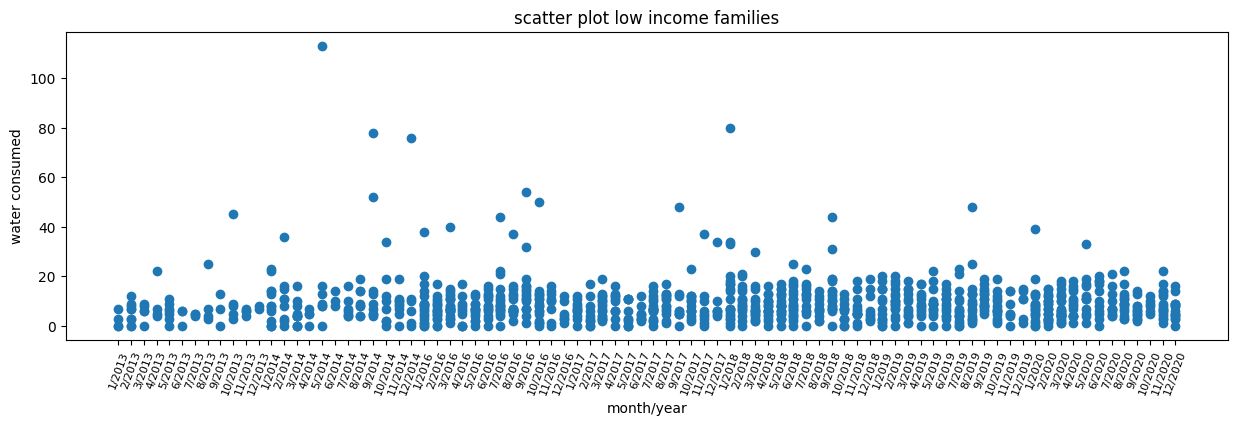

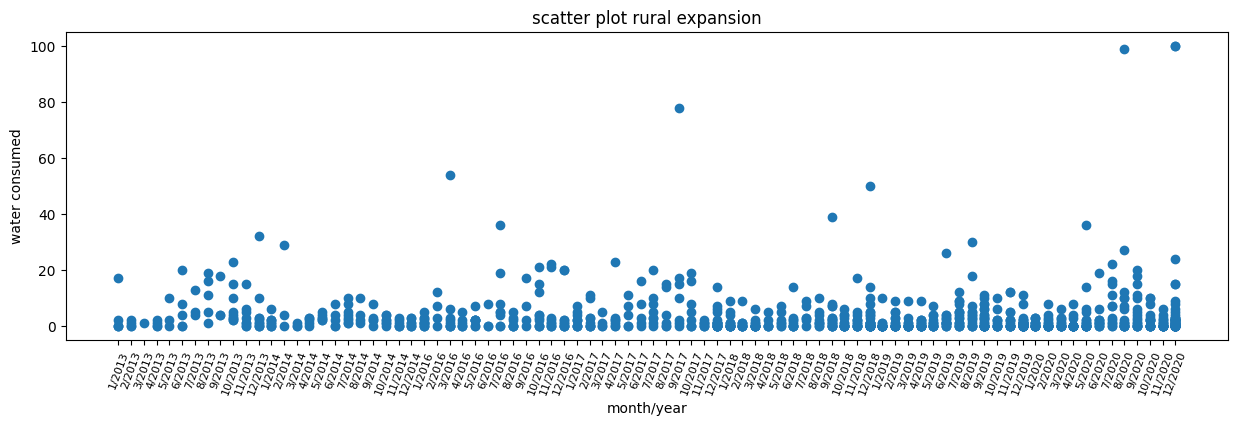

In [ ]:
def scatter_graph(consumertype_df, consumertype,):
  consumertype_df = df.loc[df['Consumer_type'] == consumertype]
  consumer_month = consumertype_df['Month'].astype(str) + '/' + consumertype_df['Year'].astype(str)
  consumer_water_consumed = [consumertype_df['Consumption']]

  plt.figure(figsize=(15,4))
  plt.scatter(consumer_month, consumer_water_consumed)

  plt.title("scatter plot " + consumertype)
  plt.xlabel("month/year")
  plt.ylabel("water consumed")
  plt.xticks(rotation=70, size=8)
  plt.show()

scatter_graph("domestic_df", "domestic")
scatter_graph("rural_domestic_df", "rural domestic")
scatter_graph("industrial_df", "industrial")
scatter_graph("rural_commercial_df", "rural commercial")
scatter_graph("construction_df", "construction")
scatter_graph("low_income_families_df", "low income families")
scatter_graph("rural_expansion_df", "rural expansion")

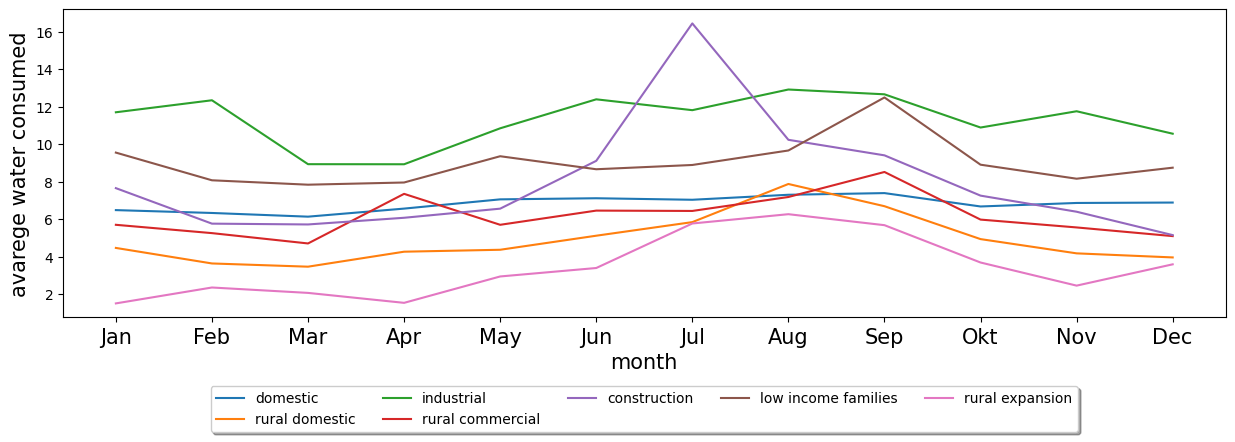

In [ ]:
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']
plt.figure(figsize=(15,4))

def monthly_avarage_consumption(consumertype_df, consumertype):
  consumertype_df = df.loc[df['Consumer_type'] == consumertype]
  avg_consumption = consumertype_df[['Month', 'Consumption']].groupby('Month').mean()
  plt.plot(xlabels, avg_consumption, label=consumertype)

monthly_avarage_consumption("domestic_df", "domestic")
monthly_avarage_consumption("rural_domestic_df", "rural domestic")
monthly_avarage_consumption("industrial_df", "industrial")
monthly_avarage_consumption("rural_commercial_df", "rural commercial")
monthly_avarage_consumption("construction_df", "construction")
monthly_avarage_consumption("low_income_families_df", "low income families")
monthly_avarage_consumption("rural_expansion_df", "rural expansion")

plt.xlabel("month", size=15)
plt.ylabel("avarege water consumed", size=15)
plt.xticks(size=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt.show()

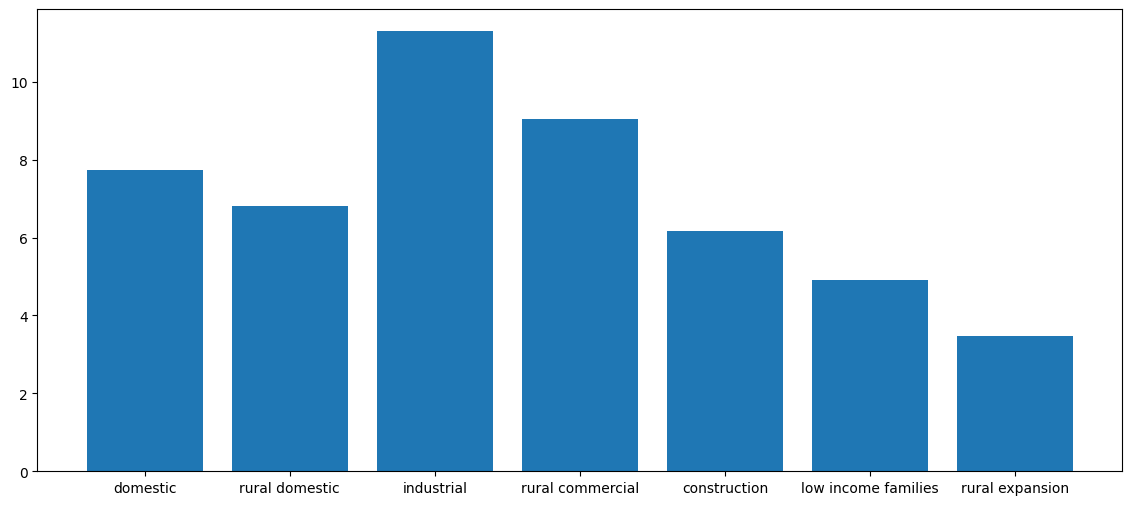

In [ ]:
xlabels = ('domestic', 'rural domestic', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural expansion')
avarage_consumption = df[['Consumption', 'Consumer_type']].groupby('Consumer_type').mean()
plt.figure(figsize=(14,6))
plt.bar(xlabels, avarage_consumption.Consumption)


plt.show()

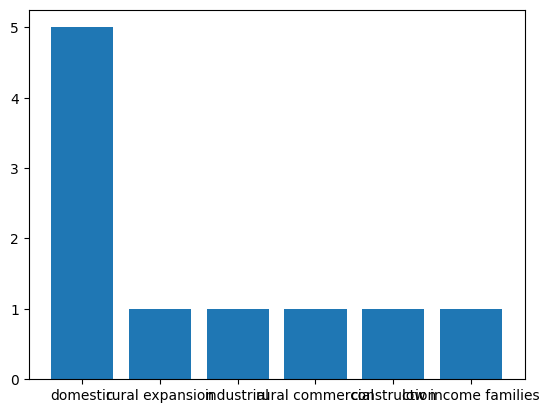

<function matplotlib.pyplot.show(close=None, block=None)>

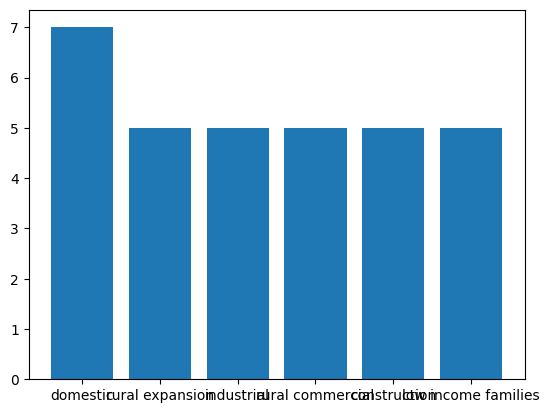

In [ ]:
nozero_df = df.loc[df['Consumption'] != 0]
xlabels = ('domestic', 'rural expansion', 'industrial', 'rural commercial', 'construction', 'low income families', 'rural expansion')

domestic_list = nozero_df.loc[nozero_df['Consumer_type'] == 'domestic'] ['Consumption'].tolist()
rural_domestic_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
industrial_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
rural_commercial_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
construction_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
low_income_families_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()
rural_expansion_list = nozero_df.loc[nozero_df['Consumer_type'] == 'rural domestic']['Consumption'].tolist()

mode_consumption = [statistics.mode(domestic_list),
                    statistics.mode(rural_domestic_list),
                    statistics.mode(industrial_list),
                    statistics.mode(rural_commercial_list),
                    statistics.mode(construction_list),
                    statistics.mode(low_income_families_list),
                    statistics.mode(rural_expansion_list),
                    ]

median_consumption = [statistics.median(domestic_list),
                      statistics.median(rural_domestic_list),
                      statistics.median(industrial_list),
                      statistics.median(rural_commercial_list),
                      statistics.median(construction_list),
                      statistics.median(low_income_families_list),
                      statistics.median(rural_expansion_list),
                    ]

plt.bar(xlabels, mode_consumption)
plt.show()

plt.bar(xlabels, median_consumption)
plt.show

## Features

dataset features


## Model


model building

# Evaluation

evaluating model


## Prediction


prediction
